#### This notebook is created on Kaggle, you can import this notebook and run it there without having any trouble.

author: [@rafaelmahesa](https://github.com/rafaelmahesa)

In [1]:
# Much of this notebook was borrowed from https://keras.io/examples/vision/captcha_ocr/ and adapted to this problem
# Credit due where credit is due

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import layers

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
from IPython.display import clear_output as cls

In [3]:
!pip install gdown

!rm -r dataset
!gdown "1wDNFEWJPtg1y73Oqxaa8CeR2djTR8Bw3" -O dataset.zip
!unzip dataset.zip -d dataset

cls()

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
df = pd.read_csv('/kaggle/working/dataset/data-modified-localized-clean/train-aug/updated_labels.csv')

In [6]:
df['images_path'] = df['images_path'].str.replace('.png', '.jpg')

/tmp/ipykernel_24/3187908284.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['images_path'] = df['images_path'].str.replace('.png', '.jpg')


In [7]:
df.head(10)

,labels,images_path
0,B187EDA,DataTrain4-0.jpg
1,B187EDA,DataTrain4-1.jpg
2,B187EDA,DataTrain4-2.jpg
3,B187EDA,DataTrain4-3.jpg
4,B187EDA,DataTrain4-4.jpg
5,B187EDA,DataTrain4-5.jpg
6,B187EDA,DataTrain4-6.jpg
7,B187EDA,DataTrain4-7.jpg
8,B187EDA,DataTrain4-8.jpg
9,B187EDA,DataTrain4-9.jpg


In [8]:
df.images_path = '/kaggle/working/dataset/data-modified-localized-clean/train-aug/data/' + df.images_path

In [9]:
df.head(10)

,labels,images_path
0,B187EDA,/kaggle/working/dataset/data-modified-localize...
1,B187EDA,/kaggle/working/dataset/data-modified-localize...
2,B187EDA,/kaggle/working/dataset/data-modified-localize...
3,B187EDA,/kaggle/working/dataset/data-modified-localize...
4,B187EDA,/kaggle/working/dataset/data-modified-localize...
5,B187EDA,/kaggle/working/dataset/data-modified-localize...
6,B187EDA,/kaggle/working/dataset/data-modified-localize...
7,B187EDA,/kaggle/working/dataset/data-modified-localize...
8,B187EDA,/kaggle/working/dataset/data-modified-localize...
9,B187EDA,/kaggle/working/dataset/data-modified-localize...


In [10]:
labels = df.labels.values.tolist()
images = df.images_path.values.tolist()

In [11]:
MAX_LENGTH = max([len(label) for label in labels])

labels = [label.ljust(MAX_LENGTH) for label in labels]

characters = set(char for label in labels for char in label if char != ' ')
characters = sorted(list(characters))

In [12]:
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  35600
Number of labels found:  35600
Number of unique characters:  36
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [13]:
BATCH_SIZE = 128
IMG_WIDTH = 240
IMG_HEIGHT = 80

In [14]:
with strategy.scope():
    char_to_num = layers.StringLookup(
        vocabulary=characters, mask_token=None
    )

    num_to_char = layers.StringLookup(
        vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
    )

In [15]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    size = len(images)
    indices = np.arange(size)
    
    if shuffle:
        np.random.shuffle(indices)
        
    train_samples = int(size * train_size)
    
    X_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    X_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    
    return X_train, X_valid, y_train, y_valid

In [16]:
X_train, X_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

In [17]:
def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.transpose(img, perm=[1, 0, 2])

    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
        
    return {"image": img, "label": label}

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [19]:
# plot_images(train_dataset)

In [20]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost
        
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        return y_pred

In [21]:
def build_model():
    input_img = layers.Input(
        shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    
    x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(input_img)
    x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv3")(x)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    
    x = layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv4")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv5")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv6")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    
    x = layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv7")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv8")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv9")(x)
    x = layers.MaxPooling2D((2, 2), name="pool3")(x)
    
    x = layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv10")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv11")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv12")(x)
    x = layers.MaxPooling2D((2, 2), name="pool4")(x)
    
    new_shape = ((IMG_WIDTH // 16), (IMG_HEIGHT // 16) * 128)
    
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)
    
    output = CTCLayer(name="ctc_loss")(labels, x)

    model = tf.keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(optimizer=opt)
    
    return model

In [22]:
with strategy.scope():
    model = build_model()

In [23]:
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 240, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 240, 80, 32)  320         ['image[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 240, 80, 32)  9248        ['Conv1[0][0]']                  
                                                                                                  
 Conv3 (Conv2D)                 (None, 240, 80, 64)  18496       ['Conv2[0][0]']       

In [24]:
EPOCHS = 200
PATIENCE = 5

In [25]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=PATIENCE, restore_best_weights=True
)

In [26]:
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=[es],
)

Epoch 1/200
251/251 [==============================] - 128s 357ms/step - loss: 21.1665 - val_loss: 17.9608
Epoch 2/200
251/251 [==============================] - 81s 322ms/step - loss: 15.6271 - val_loss: 12.4659
Epoch 3/200
251/251 [==============================] - 82s 326ms/step - loss: 9.4887 - val_loss: 5.5388
Epoch 4/200
251/251 [==============================] - 81s 321ms/step - loss: 4.5703 - val_loss: 1.9084
Epoch 5/200
251/251 [==============================] - 81s 323ms/step - loss: 2.0156 - val_loss: 0.6147
Epoch 6/200
251/251 [==============================] - 81s 323ms/step - loss: 1.0072 - val_loss: 0.3125
Epoch 7/200
251/251 [==============================] - 81s 323ms/step - loss: 0.5576 - val_loss: 0.1399
Epoch 8/200
251/251 [==============================] - 81s 321ms/step - loss: 0.4049 - val_loss: 0.1033
Epoch 9/200
251/251 [==============================] - 81s 322ms/step - loss: 0.2840 - val_loss: 0.0636
Epoch 10/200
251/251 [==============================] - 81s

In [27]:
prediction_model = tf.keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

In [28]:
model.save('model.h5')
prediction_model.save('prediction_model.h5')

In [29]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :MAX_LENGTH
    ]
    
    output_text = []
    
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
        
    return output_text

4/4 [==============================] - 3s 23ms/step


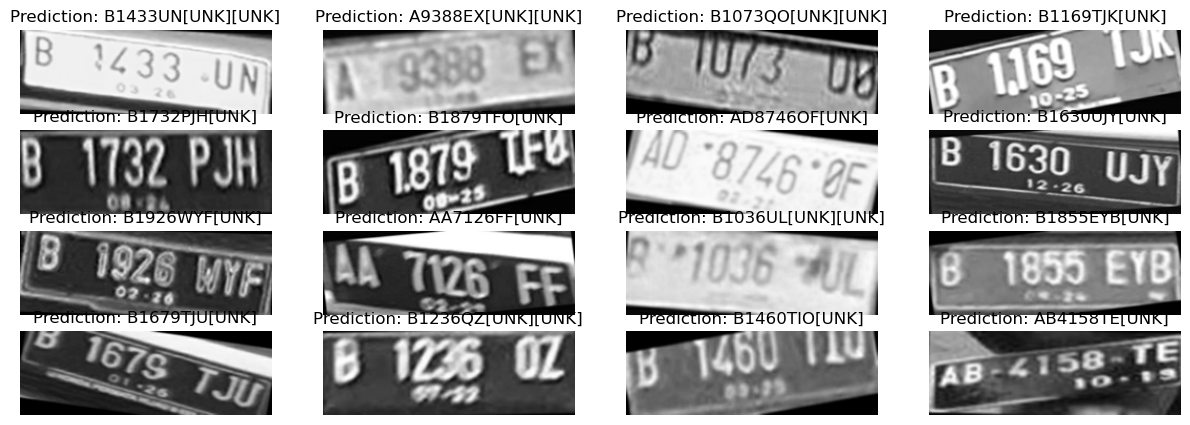

In [30]:
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts) // 8):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [31]:
df_test = pd.read_csv('/kaggle/working/dataset/data-modified-localized-clean/test/DataTest_WithAnswer.csv')
df_test['Name of File'] = df_test['Name of File'].str.replace('.png', '.jpg')
df_test['Name of File'] = '/kaggle/working/dataset/data-modified-localized-clean/test/data/' + df_test['Name of File']

# drop nan
df_test = df_test.dropna()

/tmp/ipykernel_24/1264447318.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test['Name of File'] = df_test['Name of File'].str.replace('.png', '.jpg')


In [32]:
df_test

,Name of File,Answer
0,/kaggle/working/dataset/data-modified-localize...,AD7034OE
1,/kaggle/working/dataset/data-modified-localize...,A9388EX
2,/kaggle/working/dataset/data-modified-localize...,B16TB
3,/kaggle/working/dataset/data-modified-localize...,B1661TKZ
4,/kaggle/working/dataset/data-modified-localize...,AD3772ABE
...,...,...
95,/kaggle/working/dataset/data-modified-localize...,B1285UL
96,/kaggle/working/dataset/data-modified-localize...,AB8644PK
97,/kaggle/working/dataset/data-modified-localize...,AG9718EG
98,/kaggle/working/dataset/data-modified-localize...,B1509UN


In [33]:
test_labels = df_test.Answer.values.tolist()
test_images = df_test['Name of File'].values.tolist()

In [34]:
MAX_LENGTH = max([len(label) for label in test_labels])

test_labels = [label.ljust(MAX_LENGTH) for label in test_labels]

test_characters = set(char for label in test_labels for char in label if char != ' ')
test_characters = sorted(list(test_characters))

In [35]:
print("Number of images found: ", len(test_images))
print("Number of labels found: ", len(test_labels))
print("Number of unique characters: ", len(test_characters))
print("Characters present: ", test_characters)

Number of images found:  99
Number of labels found:  99
Number of unique characters:  36
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [36]:
X_test, y_test = np.array(test_images), np.array(test_labels)

In [37]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

test_dataset = (
    test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [38]:
import matplotlib.pyplot as plt

def plot_image(images, rows=None, cols=None):
    if isinstance(images, np.ndarray):
        # Call the original plot_image function
        plt.imshow(images)
        plt.show()
    else:
        fig, axs = plt.subplots(rows, cols, figsize=(20,20))
        for i, img in enumerate(images):
            if axs.ndim == 1:
                ax = axs[i]
            else:
                ax = axs[i // cols, i % cols]
            ax.imshow(img)
        plt.show()

4/4 [==============================] - 0s 34ms/step


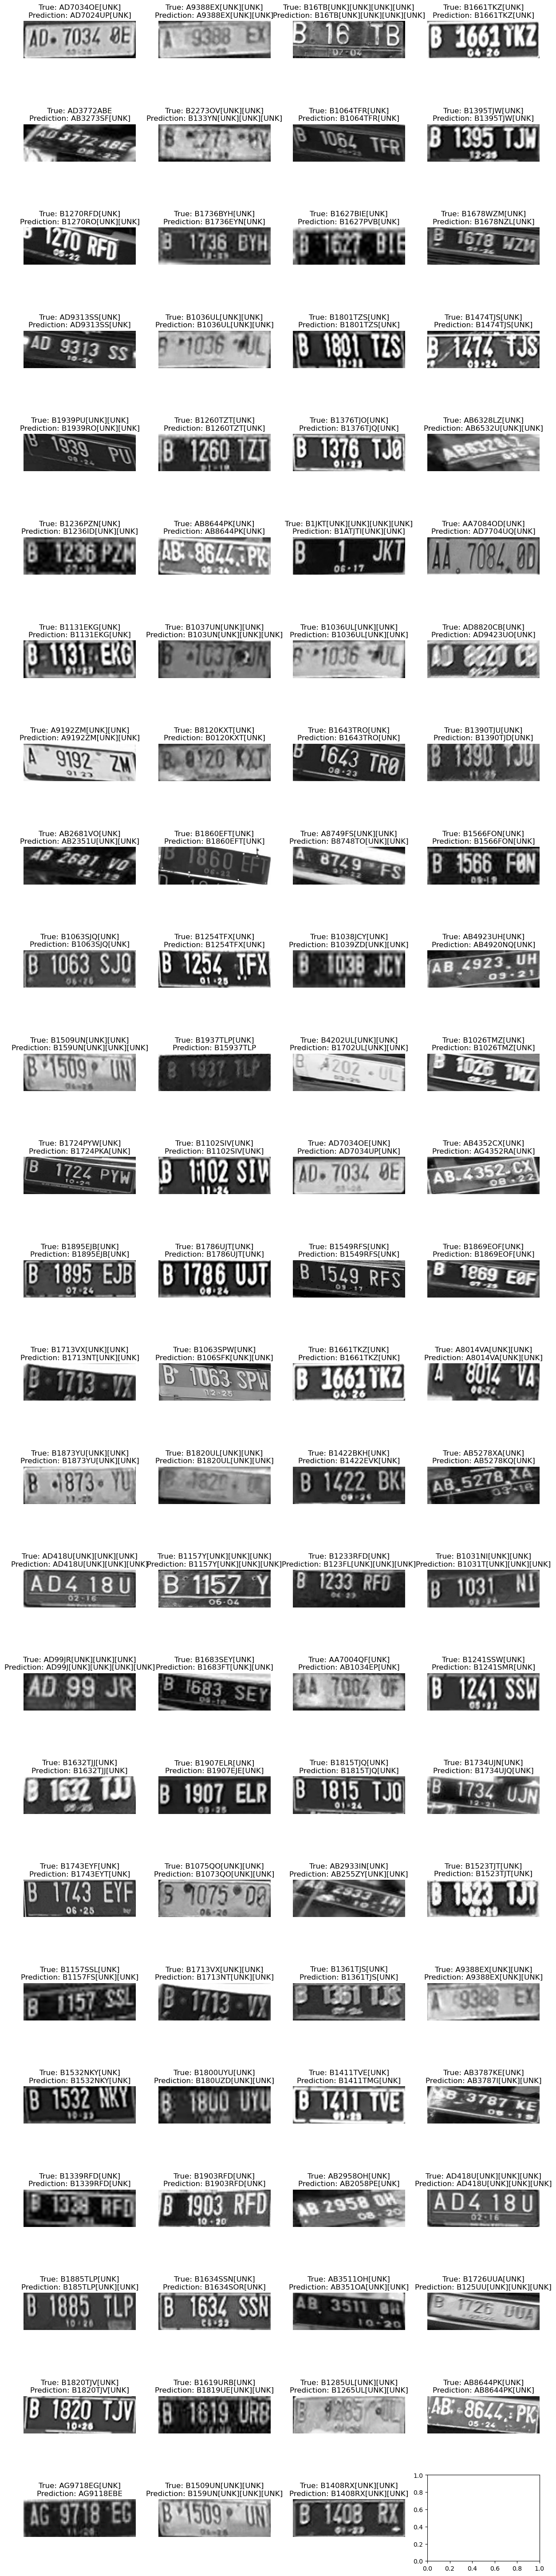

In [40]:
import math
import matplotlib.pyplot as plt

# Iterate through all the batches in the test_dataset
for batch in test_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    # Determine the number of images in the batch
    num_images = len(batch_images)
    
    # Calculate the number of rows needed to display all the images in a grid with 4 columns
    num_rows = math.ceil(num_images / 4)
    
    # Create a figure with subplots to display the images
    fig, axes = plt.subplots(num_rows, 4, figsize=(15, num_rows * 3))
    
    # Loop through the images in the batch
    for i in range(num_images):
        # Get the current image
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        
        # Plot the image using matplotlib
        row = i // 4
        col = i % 4
        axes[row, col].imshow(img, cmap="gray")
        axes[row, col].set_title(f"True: {orig_texts[i]}\nPrediction: {pred_texts[i]}")
        axes[row, col].axis('off')
        
plt.show()
